In [276]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from store_data import DataStore
from utilities import get_building_id, get_location_id, get_lat_lng, starting_date, time_delta, year, get_date, timestamp_to_string, epoch_to_date

from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [141]:
raw_data_path = 'data1/'

In [142]:
for dirpath, dirnames, filenames in os.walk(raw_data_path):
    print(dirpath)

data1/


In [144]:
energystats = pd.DataFrame()
exclude_files = ['USA_AK_FAIRBANKS_temperature_usage.csv', 'USA_CA_LOS_ANGELES_temperature_usage.csv',
                 'USA_IL_CHICAGO-OHARE_temperature_usage.csv', 'USA_MN_MINNEAPOLIS_temperature_usage.csv', 
                 'USA_TX_HOUSTON_temperature_usage.csv', 'USA_WA_SEATTLE_temperature_usage.csv',
                 '.DS_Store', 'Holidays.csv', 'energystats.csv', 'dataset.csv', 'All_locations_temperature_usage.csv']
for file_ in filenames:
    if file_ in exclude_files:
        continue
    if '2004' in file_ and 'USA_' in file_:
        df = pd.read_csv(dirpath+file_)
        building_type = file_[:file_.index("2004")]
        location = file_[file_.index("USA_"):file_.index(".csv")]
        df['building_type'] = building_type
        df['location'] = location
    else:
        continue
    energystats = pd.concat((df, energystats), axis=0)

In [145]:
energystats.count()

Cooling:Electricity [kW](Hourly)              1681920
Date/Time                                     1681920
Electricity:Facility [kW](Hourly)             1681920
Electricity:Facility [kW](Monthly)                  0
Fans:Electricity [kW](Hourly)                 1681920
Gas:Facility [kW](Hourly)                     1681920
Gas:Facility [kW](Monthly)                          0
Heating:Electricity [kW](Hourly)              1681920
Heating:Gas [kW](Hourly)                      1681920
InteriorEquipment:Electricity [kW](Hourly)    1681920
InteriorEquipment:Gas [kW](Hourly)             946080
InteriorLights:Electricity [kW](Hourly)       1681920
Water Heater:WaterSystems:Gas [kW](Hourly)    1366560
building_type                                 1681920
location                                      1681920
dtype: int64

In [146]:
energystats.head(5)

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type,location
0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS
4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS


In [147]:
energystats.groupby('location').count()

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type
location,,,,,,,,,,,,,,
USA_AK_FAIRBANKS,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_AZ_PHOENIX,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_CA_LOS_ANGELES,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_CA_SAN_FRANCISCO,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_CO_BOULDER,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_GA_ATLANTA,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_IL_CHICAGO-OHARE,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_MD_BALTIMORE,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160
USA_MN_MINNEAPOLIS,140160,140160,140160,0,140160,140160,0,140160,140160,140160,78840,140160,113880,140160


In [148]:
energystats['location_id'] = energystats['location'].apply(get_location_id)
energystats['building_id'] = energystats['building_type'].apply(get_building_id)

In [149]:
energystats['Date'] = energystats['Date/Time'].apply(get_date)
energystats.Date = energystats.Date.astype(str)
energystats.head(5)

,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),building_type,location,location_id,building_id,Date
0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01
4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,1.0116,NaN,5.481225,NaN,RefBldgWarehouseNew,USA_AK_FAIRBANKS,1,16,01/01


In [151]:
holidays = pd.read_csv("data1/Holidays.csv")
energystats_holidays = pd.merge(energystats, holidays,
                                on='Date', how='outer')

energystats_holidays.count()

Cooling:Electricity [kW](Hourly)              1681920
Date/Time                                     1681920
Electricity:Facility [kW](Hourly)             1681920
Electricity:Facility [kW](Monthly)                  0
Fans:Electricity [kW](Hourly)                 1681920
Gas:Facility [kW](Hourly)                     1681920
Gas:Facility [kW](Monthly)                          0
Heating:Electricity [kW](Hourly)              1681920
Heating:Gas [kW](Hourly)                      1681920
InteriorEquipment:Electricity [kW](Hourly)    1681920
InteriorEquipment:Gas [kW](Hourly)             946080
InteriorLights:Electricity [kW](Hourly)       1681920
Water Heater:WaterSystems:Gas [kW](Hourly)    1366560
building_type                                 1681920
location                                      1681920
location_id                                   1681920
building_id                                   1681920
Date                                          1681920
Holiday                     

In [10]:
"""
data_store = DataStore('35.227.50.121')
data_store.connect_to_database()
data_store.store_data(energystats)
"""

"\ndata_store = DataStore('35.227.50.121')\ndata_store.connect_to_database()\ndata_store.store_data(energystats)\n"

In [156]:
temperaturestats = pd.DataFrame()
locations = ['USA_AK_FAIRBANKS', 'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS', 'USA_TX_HOUSTON', 'USA_WA_SEATTLE',
             'USA_NV_LAS_VEGAS', 'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']
for location in locations:
    loc_temp_usage = pd.read_csv(dirpath+location+'_temperature_usage.csv')
    loc_temp_usage['Date'] = loc_temp_usage['time'].apply(epoch_to_date)
    loc_temp_usage['location'] = location
    temperaturestats = pd.concat((loc_temp_usage, temperaturestats), axis=0)
temperaturestats.drop(columns=['Unnamed: 0'], inplace=True)
temperaturestats.to_csv('data/All_locations_temperature_usage.csv')

In [157]:
temperaturestats.groupby('location').count()

,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover,Date
location,,,,,,,,,
USA_AK_FAIRBANKS,366,366,366,366,366,366,366,366,366
USA_AZ_PHOENIX,366,366,366,366,366,366,366,366,366
USA_CA_LOS_ANGELES,366,366,366,366,366,366,366,366,366
USA_CA_SAN_FRANCISCO,366,366,366,366,366,366,366,366,366
USA_CO_BOULDER,366,366,366,366,366,366,366,366,366
USA_GA_ATLANTA,366,366,366,366,366,366,366,366,366
USA_IL_CHICAGO-OHARE,366,366,366,366,366,366,366,366,366
USA_MD_BALTIMORE,366,366,366,366,366,366,366,366,366
USA_MN_MINNEAPOLIS,366,366,366,366,366,366,366,366,366


In [158]:
temperaturestats.head(5)

,time,sunriseTime,sunsetTime,temperatureHigh,dewPoint,humidity,windSpeed,cloudCover,Date,location
0,1072940400,1072967052,1073000832,51.77,6.76,0.22,3.89,0.69,01/01,USA_CO_BOULDER
1,1073026800,1073053458,1073087281,42.15,20.25,0.49,1.81,0.89,01/02,USA_CO_BOULDER
2,1073113200,1073139862,1073173731,27.35,18.89,0.76,0.94,0.95,01/03,USA_CO_BOULDER
3,1073199600,1073226264,1073260183,25.10,3.76,0.52,2.13,0.41,01/04,USA_CO_BOULDER
4,1073286000,1073312663,1073346637,6.56,-7.72,0.52,1.59,0.62,01/05,USA_CO_BOULDER


In [159]:
temperature_usage = pd.read_csv("data/All_locations_temperature_usage.csv")
dataset = pd.merge(energystats_holidays, temperature_usage,
                   on=['Date','location'], how='inner')

In [160]:
dataset = dataset.drop(columns=['Unnamed: 0'])

In [161]:
dataset.count()

Cooling:Electricity [kW](Hourly)              1681920
Date/Time                                     1681920
Electricity:Facility [kW](Hourly)             1681920
Electricity:Facility [kW](Monthly)                  0
Fans:Electricity [kW](Hourly)                 1681920
Gas:Facility [kW](Hourly)                     1681920
Gas:Facility [kW](Monthly)                          0
Heating:Electricity [kW](Hourly)              1681920
Heating:Gas [kW](Hourly)                      1681920
InteriorEquipment:Electricity [kW](Hourly)    1681920
InteriorEquipment:Gas [kW](Hourly)             946080
InteriorLights:Electricity [kW](Hourly)       1681920
Water Heater:WaterSystems:Gas [kW](Hourly)    1366560
building_type                                 1681920
location                                      1681920
location_id                                   1681920
building_id                                   1681920
Date                                          1681920
Holiday                     

In [163]:
dataset.to_csv('data1/dataset.csv')

## Feature Analysis and Engineering

In [164]:
dataset = pd.read_csv('data/dataset.csv')

In [165]:
dataset_expand_holidays = pd.get_dummies(dataset['Holiday'])
dataset = pd.concat([dataset, dataset_expand_holidays], axis=1)
dataset.head(5)

,Unnamed: 0,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),...,Christmas Day,Columbus Day,Independence Day,Labor Day,Martin Luther King Day,Memorial Day,New Years Day,Presidents Day,Thanksgiving,Veterans Day
0,0,0.0,01/01 01:00:00,22.200377,NaN,6.784553,198.184686,NaN,0.0,198.184686,...,0,0,0,0,0,0,1,0,0,0
1,1,0.0,01/01 02:00:00,20.673749,NaN,5.257925,156.818509,NaN,0.0,156.818509,...,0,0,0,0,0,0,1,0,0,0
2,2,0.0,01/01 03:00:00,22.051864,NaN,6.636040,179.738632,NaN,0.0,179.738632,...,0,0,0,0,0,0,1,0,0,0
3,3,0.0,01/01 04:00:00,20.450578,NaN,5.034754,144.452862,NaN,0.0,144.452862,...,0,0,0,0,0,0,1,0,0,0
4,4,0.0,01/01 05:00:00,21.914217,NaN,6.498393,172.954875,NaN,0.0,172.954875,...,0,0,0,0,0,0,1,0,0,0


In [166]:
dataset = dataset.drop(columns=['Holiday_code', 'Holiday'])
weekday_features = pd.read_csv('data/weekday_features.csv')
weekday_features.head(5)

,Date,Day,is_weekend,is_holiday,Holiday_name
0,01/01,Thursday,0,1,New Years Day
1,01/02,Friday,0,0,NaN
2,01/03,Saturday,1,0,NaN
3,01/04,Sunday,1,0,NaN
4,01/05,Monday,0,0,NaN


In [167]:
dataset = pd.merge(dataset, weekday_features,
                   on='Date', how='inner')
dataset.count()

Unnamed: 0                                    1681920
Cooling:Electricity [kW](Hourly)              1681920
Date/Time                                     1681920
Electricity:Facility [kW](Hourly)             1681920
Electricity:Facility [kW](Monthly)                  0
Fans:Electricity [kW](Hourly)                 1681920
Gas:Facility [kW](Hourly)                     1681920
Gas:Facility [kW](Monthly)                          0
Heating:Electricity [kW](Hourly)              1681920
Heating:Gas [kW](Hourly)                      1681920
InteriorEquipment:Electricity [kW](Hourly)    1681920
InteriorEquipment:Gas [kW](Hourly)             946080
InteriorLights:Electricity [kW](Hourly)       1681920
Water Heater:WaterSystems:Gas [kW](Hourly)    1366560
building_type                                 1681920
location                                      1681920
location_id                                   1681920
building_id                                   1681920
Date                        

In [168]:
dataset["Electricity:Facility [kW](Monthly)"].fillna(0, inplace=True)
dataset["Gas:Facility [kW](Monthly)"].fillna(0, inplace=True)
dataset["InteriorEquipment:Gas [kW](Hourly)"].fillna(0, inplace=True)
dataset["Water Heater:WaterSystems:Gas [kW](Hourly)"].fillna(0, inplace=True)
dataset.head(5)

,Unnamed: 0,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),...,Martin Luther King Day,Memorial Day,New Years Day,Presidents Day,Thanksgiving,Veterans Day,Day,is_weekend,is_holiday,Holiday_name
0,0,0.0,01/01 01:00:00,22.200377,0.0,6.784553,198.184686,0.0,0.0,198.184686,...,0,0,1,0,0,0,Thursday,0,1,New Years Day
1,1,0.0,01/01 02:00:00,20.673749,0.0,5.257925,156.818509,0.0,0.0,156.818509,...,0,0,1,0,0,0,Thursday,0,1,New Years Day
2,2,0.0,01/01 03:00:00,22.051864,0.0,6.636040,179.738632,0.0,0.0,179.738632,...,0,0,1,0,0,0,Thursday,0,1,New Years Day
3,3,0.0,01/01 04:00:00,20.450578,0.0,5.034754,144.452862,0.0,0.0,144.452862,...,0,0,1,0,0,0,Thursday,0,1,New Years Day
4,4,0.0,01/01 05:00:00,21.914217,0.0,6.498393,172.954875,0.0,0.0,172.954875,...,0,0,1,0,0,0,Thursday,0,1,New Years Day


### One Hot Encoding

In [169]:
dataset_expand_days = pd.get_dummies(dataset['Day'])
dataset = pd.concat([dataset, dataset_expand_days], axis=1)
dataset.head(5)

,Unnamed: 0,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),...,is_weekend,is_holiday,Holiday_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0.0,01/01 01:00:00,22.200377,0.0,6.784553,198.184686,0.0,0.0,198.184686,...,0,1,New Years Day,0,0,0,0,1,0,0
1,1,0.0,01/01 02:00:00,20.673749,0.0,5.257925,156.818509,0.0,0.0,156.818509,...,0,1,New Years Day,0,0,0,0,1,0,0
2,2,0.0,01/01 03:00:00,22.051864,0.0,6.636040,179.738632,0.0,0.0,179.738632,...,0,1,New Years Day,0,0,0,0,1,0,0
3,3,0.0,01/01 04:00:00,20.450578,0.0,5.034754,144.452862,0.0,0.0,144.452862,...,0,1,New Years Day,0,0,0,0,1,0,0
4,4,0.0,01/01 05:00:00,21.914217,0.0,6.498393,172.954875,0.0,0.0,172.954875,...,0,1,New Years Day,0,0,0,0,1,0,0


In [170]:
dataset.columns

Index(['Unnamed: 0', 'Cooling:Electricity [kW](Hourly)', 'Date/Time',
       'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Monthly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Gas:Facility [kW](Monthly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'Day', 'is_weekend',
       'is_holiday', 'Holiday_name', 'Friday', 'Monday', 'Saturda

In [171]:
dataset_expand_building_type = pd.get_dummies(dataset['building_type'])
dataset = pd.concat([dataset, dataset_expand_building_type], axis=1)
dataset_expand_location = pd.get_dummies(dataset['location'])
dataset = pd.concat([dataset, dataset_expand_location], axis=1)
dataset.head(5)

,Unnamed: 0,Cooling:Electricity [kW](Hourly),Date/Time,Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Monthly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Gas:Facility [kW](Monthly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),...,USA_CA_LOS_ANGELES,USA_CA_SAN_FRANCISCO,USA_CO_BOULDER,USA_GA_ATLANTA,USA_IL_CHICAGO-OHARE,USA_MD_BALTIMORE,USA_MN_MINNEAPOLIS,USA_NV_LAS_VEGAS,USA_TX_HOUSTON,USA_WA_SEATTLE
0,0,0.0,01/01 01:00:00,22.200377,0.0,6.784553,198.184686,0.0,0.0,198.184686,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,01/01 02:00:00,20.673749,0.0,5.257925,156.818509,0.0,0.0,156.818509,...,0,0,0,0,0,0,0,0,0,0
2,2,0.0,01/01 03:00:00,22.051864,0.0,6.636040,179.738632,0.0,0.0,179.738632,...,0,0,0,0,0,0,0,0,0,0
3,3,0.0,01/01 04:00:00,20.450578,0.0,5.034754,144.452862,0.0,0.0,144.452862,...,0,0,0,0,0,0,0,0,0,0
4,4,0.0,01/01 05:00:00,21.914217,0.0,6.498393,172.954875,0.0,0.0,172.954875,...,0,0,0,0,0,0,0,0,0,0


In [172]:
dataset.to_csv('data/dataset.csv')

### Predict Energy consumption

In [240]:
dataset = pd.read_csv('data1/dataset.csv')

In [174]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Monthly)', 'Fans:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Gas:Facility [kW](Monthly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'Day', 'is_weekend',
       'is_holiday', 'Holiday_name', 'Friday', 'M

In [255]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER']]

In [238]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),...,USA_IL_CHICAGO-OHARE,USA_MN_MINNEAPOLIS,USA_TX_HOUSTON,USA_WA_SEATTLE,USA_NV_LAS_VEGAS,USA_CA_SAN_FRANCISCO,USA_AZ_PHOENIX,USA_GA_ATLANTA,USA_MD_BALTIMORE,USA_CO_BOULDER
count,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,...,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06,1.681920e+06
mean,5.588932e+01,2.026355e+02,1.707438e+01,9.162392e+01,9.860414e-01,6.356293e+01,5.320615e+01,1.016023e+01,4.099851e+01,1.790076e+01,...,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02
std,1.333567e+02,3.242529e+02,2.739628e+01,1.959991e+02,6.944747e+00,1.750998e+02,8.320485e+01,1.841612e+01,7.496627e+01,5.677064e+01,...,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01
min,0.000000e+00,1.925019e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+00,0.000000e+00,2.750027e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.558064e+01,5.147965e-01,2.188671e+00,0.000000e+00,0.000000e+00,8.089532e+00,0.000000e+00,3.788942e+00,2.000000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.525502e-01,6.191023e+01,4.375339e+00,1.612785e+01,0.000000e+00,1.063959e-06,2.064387e+01,2.653365e+00,1.586394e+01,1.165121e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.510995e+01,2.191530e+02,2.552694e+01,8.384342e+01,0.000000e+00,4.634194e+01,5.323874e+01,9.905768e+00,4.351334e+01,8.775903e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.550041e+02,1.849288e+03,2.803934e+02,4.779020e+03,3.049323e+02,4.765562e+03,4.485665e+02,9.179980e+01,4.485665e+02,7.838779e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


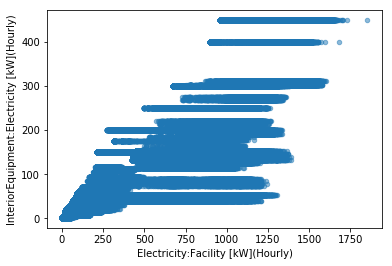

In [187]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="InteriorEquipment:Electricity [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

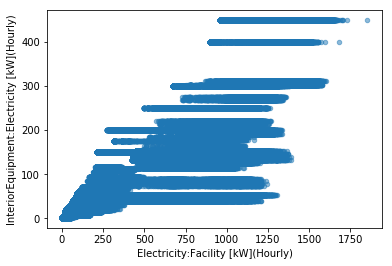

In [241]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="InteriorEquipment:Electricity [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

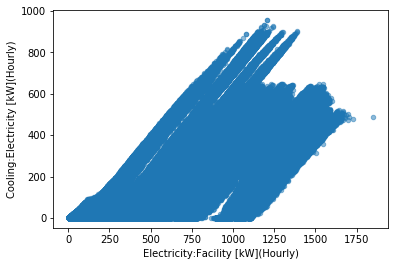

In [242]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="Cooling:Electricity [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

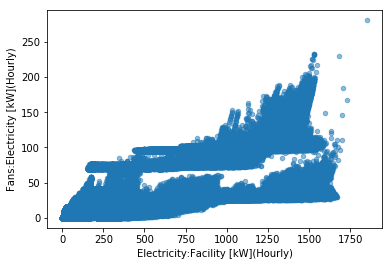

In [243]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="Fans:Electricity [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

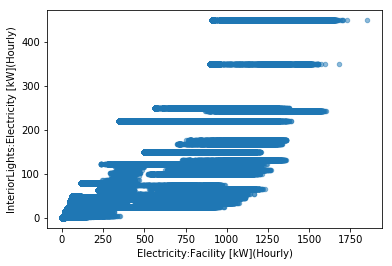

In [244]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="InteriorLights:Electricity [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

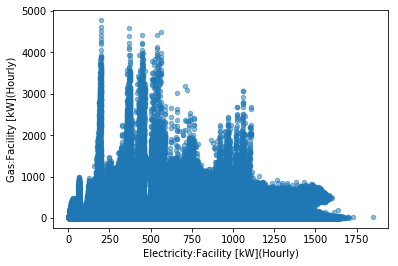

In [245]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="Gas:Facility [kW](Hourly)", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

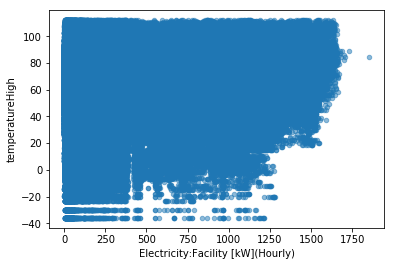

In [246]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="temperatureHigh", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

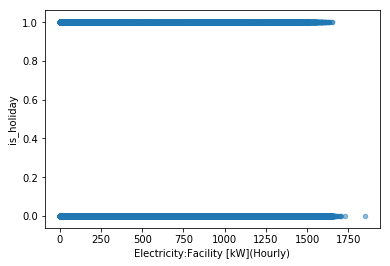

In [247]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="is_holiday", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

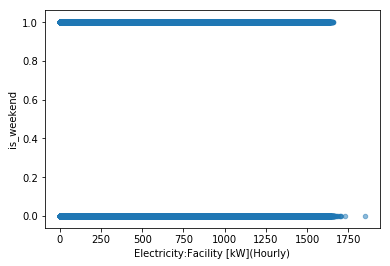

In [248]:
dataset_numeric.plot(kind="scatter", x="Electricity:Facility [kW](Hourly)", y="is_weekend", alpha=0.5)
#plt.savefig('scatter.png')
#scatter_matrix(dataset_numeric, alpha=0.2, figsize=(25,25), diagonal='kde')
plt.show()

In [216]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)             1.000000
InteriorEquipment:Electricity [kW](Hourly)    0.890501
Cooling:Electricity [kW](Hourly)              0.876445
Fans:Electricity [kW](Hourly)                 0.835990
InteriorLights:Electricity [kW](Hourly)       0.825711
RefBldgHospitalNew                            0.681053
Gas:Facility [kW](Hourly)                     0.449607
InteriorEquipment:Gas [kW](Hourly)            0.416995
RefBldgLargeOfficeNew                         0.416291
Heating:Gas [kW](Hourly)                      0.409033
Water Heater:WaterSystems:Gas [kW](Hourly)    0.155387
RefBldgSecondarySchoolNew                     0.138272
temperatureHigh                               0.066540
RefBldgLargeHotelNew                          0.062014
dewPoint                                      0.052271
is_weekend                                    0.034288
USA_TX_HOUSTON                                0.031984
USA_AZ_PHOENIX                                0.029572
Monday    

In [266]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(dataset_numeric)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER'])

In [267]:
scaled_df.head(5)

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly),...,USA_IL_CHICAGO-OHARE,USA_MN_MINNEAPOLIS,USA_TX_HOUSTON,USA_WA_SEATTLE,USA_NV_LAS_VEGAS,USA_CA_SAN_FRANCISCO,USA_AZ_PHOENIX,USA_GA_ATLANTA,USA_MD_BALTIMORE,USA_CO_BOULDER
0,-0.419097,-0.556464,-0.375592,0.543680,-0.141984,0.768829,-0.627302,-0.551703,-0.473777,-0.315317,...,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511
1,-0.419097,-0.561173,-0.431316,0.332627,-0.141984,0.532586,-0.627302,-0.551703,-0.473777,-0.315317,...,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511
2,-0.419097,-0.556922,-0.381013,0.449567,-0.141984,0.663483,-0.627302,-0.551703,-0.473777,-0.315317,...,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511
3,-0.419097,-0.561861,-0.439462,0.269537,-0.141984,0.461965,-0.627302,-0.551703,-0.473777,-0.315317,...,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511
4,-0.419097,-0.557347,-0.386037,0.414956,-0.141984,0.624741,-0.627302,-0.551703,-0.473777,-0.315317,...,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511,-0.301511


In [268]:
dataset_features = scaled_df[['Cooling:Electricity [kW](Hourly)',
                                    'InteriorEquipment:Electricity [kW](Hourly)',
                                    'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew', 'USA_AK_FAIRBANKS',
       'USA_CA_LOS_ANGELES', 'USA_IL_CHICAGO-OHARE', 'USA_MN_MINNEAPOLIS',
       'USA_TX_HOUSTON', 'USA_WA_SEATTLE', 'USA_NV_LAS_VEGAS',
        'USA_CA_SAN_FRANCISCO', 'USA_AZ_PHOENIX', 'USA_GA_ATLANTA', 'USA_MD_BALTIMORE', 'USA_CO_BOULDER',
        'time', 'sunriseTime', 'sunsetTime']]
dataset_labels = scaled_df[['Electricity:Facility [kW](Hourly)']]

In [260]:
# X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.01)
# tscv = TimeSeriesSplit(n_splits=10)
kf = KFold(n_splits=2, random_state=None, shuffle=False)
rmse = []
r2 = []
indices = []
for train_index, test_index in tscv.split(scaled_df):
    X_train, X_test = dataset_features.iloc[train_index], dataset_features.iloc[test_index]
    indices.append(train_index)
    y_train, y_test = dataset_labels.iloc[train_index], dataset_labels.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    expected = y_test
    predicted = model.predict(X_test)
    rmse.append(mse(expected, predicted))
    r2.append(r2_score(expected, predicted))
    
print('Linear Regression model')
print('Mean Squared Error: {}'.format(rmse))
print('Coefficient of Determination: {}'.format(r2))

Linear Regression model
Mean Squared Error: [2.7120541872709545e+18, 0.0002851022480471149, 0.00029959524711219854, 7.018088184155491e+19, 1.480376843519622e+20, 0.0002900261104693511, 2.098913748589537e+17, 9.572483730553969e+17, 2.0545396872975212e+18, 7.140554997021288e+18]
Coefficient of Determination: [-1.0599411799765279e+20, 0.9899287212559039, 0.9910187030942936, -2.0281324515227245e+21, -4.23254260968526e+21, 0.9918072243597698, -5.924295379649987e+18, -2.9945631218405896e+19, -7.2075432665942794e+19, -2.8147498175140243e+20]


In [275]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.1)

In [270]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Linear Regression model
Mean Squared Error: 0.010
Coefficient of Determination: 0.991


In [263]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))

Ridge model
Mean Squared Error: 0.000
Coefficient of Determination: 0.991


In [264]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Random Forest model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Random Forest model
Mean squared error = 0.000
R2 score = 0.999


In [271]:
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Ridge model
Mean squared error = 0.009
R2 score = 0.991


In [277]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.059
R2 score = 0.941


In [283]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Lasso
Mean squared error = 0.070
R2 score = 0.930
